In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/DIV2k')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DIV2k


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import cv2
import numpy as np
import math
import os
from skimage.metrics import structural_similarity as ssim
import glob
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time

#Define if cuda exist
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Define MSE function
def mse(target, src):
    return F.mse_loss(target, src).item()  # Convert tensor to float

# Define PSNR function
def psnr(target, src):
    mse_value = F.mse_loss(target, src)
    if mse_value == 0:
        return float('inf')  # Avoid division by zero
    max_pixel = 1.0  # Assuming images are normalized between [0,1]
    return (20 * torch.log10(torch.tensor(max_pixel) / torch.sqrt(mse_value))).item()

# Define SSIM function
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

def ssim(target, src):
    return ssim_metric(target.unsqueeze(0), src.unsqueeze(0)).item()  # Add batch dim for SSIM

# Compare function
def compare_images(target, src):
    scores = []
    scores.append(psnr(target, src))
    scores.append(mse(target, src))
    scores.append(ssim(target, src))  # SSIM for RGB images in PyTorch
    return scores

In [ ]:
#generate low resolution images from high resolution images
def generate_lr_image(hr_image, scale_factor = 4):
  height, width, _ = hr_image.shape

  if hr_image is None:
    print("Image is not loaded")
  else:
    lr_image = cv2.resize(hr_image, (width // scale_factor, height // scale_factor), interpolation=cv2.INTER_CUBIC)
    lr_image = cv2.resize(lr_image, (width, height), interpolation=cv2.INTER_CUBIC)
    return lr_image

#Directory
input_dir = '/content/drive/MyDrive/DIV2k/train_hr'
output_dir = '/content/drive/MyDrive/DIV2k/train_lr'

#Check if directory exist if not make it
if not os.path.exists(output_dir):
  os.makedirs('/content/drive/MyDrive/DIV2k/train_lr')

#list of the input directories
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', 'png', 'jpeg'))]

#process each image and save it
for idx, image_file in enumerate(image_files):
  #Load high resolution image
  hr_image = cv2.imread(os.path.join(input_dir, image_file))

  if hr_image is None:
    print("Error loading this file")
    continue

  #Generate low-resolution image
  lr_image = generate_lr_image(hr_image, scale_factor=4)

  #save images
  output_path = os.path.join(output_dir, f"{image_file}")
  cv2.imwrite(output_path, lr_image)

  print("Processed and saved {}: ".format(output_path))

print("\nFinished processing")

Processed and saved /content/drive/MyDrive/DIV2k/train_lr/0002.png: 


KeyboardInterrupt: 

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

count = 0
max_img = 5

for file in os.listdir('/content/drive/MyDrive/DIV2k/train_hr'):
    if count >= max_img:
        break

    hr_path = f'/content/drive/MyDrive/DIV2k/train_hr/{file}'
    lr_path = f'/content/drive/MyDrive/DIV2k/train_lr/{file}'

    if not os.path.exists(hr_path) or not os.path.exists(lr_path):
        print(f"Skipping {file}: One of the images is missing.")
        continue

    target = cv2.imread(hr_path)
    src = cv2.imread(lr_path)

    if target is None or src is None:
        print(f"Skipping {file}: Could not load one or both images.")
        continue

    try:
        # Convert OpenCV images (H, W, C) to PyTorch tensors (C, H, W)
        target = transform(target)  # Convert to tensor
        src = transform(src)

        scores = compare_images(target, src)
        print(f'Comparing Images: {file}')
        print(f'PSNR: {scores[0]:.2f}')
        print(f'MSE: {scores[1]:.8f}')
        print(f'SSIM: {scores[2]:.4f}\n')
        count += 1
    except Exception as e:
        print(f"Error processing {file}: {e}")

Comparing Images: 0002.png
PSNR: 22.43
MSE: 0.00571921
SSIM: 0.5974

Comparing Images: 0001.png
PSNR: 28.37
MSE: 0.00145390
SSIM: 0.8000

Comparing Images: 0004.png
PSNR: 27.79
MSE: 0.00166423
SSIM: 0.8655

Comparing Images: 0006.png
PSNR: 29.80
MSE: 0.00104654
SSIM: 0.8808

Comparing Images: 0003.png
PSNR: 21.96
MSE: 0.00636418
SSIM: 0.6583



In [ ]:
#Loading dataset function
class SRCNNDataset(Dataset):
  def __init__(self, hr_image_dir, lr_image_dir, patch_size = 32, num_patches=150, transform=None):
    self.hr_image_dir = hr_image_dir
    self.lr_image_dir = lr_image_dir
    self.patch_size = patch_size
    self.num_patches = num_patches
    self.transform = transform if transform else transforms.ToTensor() # applying ToTensor(), the shape would be (C, H, W)


    #os.listdir basically list the image files in string
    #sorted is to make it list in lexigraphical order
    #So tat later can be able to map the low and high resolution image together
    self.hr_images = sorted(os.listdir(self.hr_image_dir))
    self.lr_images = sorted(os.listdir(self.lr_image_dir))

    # Debugging: Print first 5 sorted filenames
    print("First 5 HR Images:", self.hr_images[250:270])
    print("First 5 LR Images:", self.lr_images[250:270])

  def __len__(self):
    return len(self.hr_images)

  def __getitem__(self, idx):
    hr_image_path = os.path.join(self.hr_image_dir, self.hr_images[idx])
    lr_image_path = os.path.join(self.lr_image_dir, self.lr_images[idx])

    #Ensures Consistent Input Format: Any inconsistency in the number of channels (e.g., grayscale or CMYK images) is resolved.
    #Model Compatibility: Models trained on RGB data require all images to follow the same format.
    hr_image = Image.open(hr_image_path).convert("RGB")
    lr_image = Image.open(lr_image_path).convert("RGB")

    if self.transform:
      hr_image = self.transform(hr_image)
      lr_image = self.transform(lr_image)

    #Extract patches
    patches_hr, patches_lr = [], []
    _, h, w = hr_image.shape

    for _ in range(self.num_patches):
      #Randomly select top left corners for cropping
      x = random.randint(0, w - self.patch_size)
      y = random.randint(0, h - self.patch_size)

      #Crop patches from tensors
      hr_patch = hr_image[:, y:y+self.patch_size, x:x+self.patch_size]
      lr_patch = lr_image[:, y:y+self.patch_size, x:x+self.patch_size]

      patches_hr.append(hr_patch)  # Each patch is [3, 32, 32]
      patches_lr.append(lr_patch)

    return torch.stack(patches_lr), torch.stack(patches_hr) #torch.stack(patches_lr) → Shape: [150, 3, 32, 32]
    #return torch.stack(patches_lr).view(-1, 3, self.patch_size, self.patch_size),torch.stack(patches_hr).view(-1, 3, self.patch_size, self.patch_size)#-1 automatically calculates the number of patches (batch_size * num_patches).


#transform
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
dataset = SRCNNDataset('/content/drive/MyDrive/DIV2k/train_hr', '/content/drive/MyDrive/DIV2k/train_lr')


First 5 HR Images: ['0251.png', '0252.png', '0253.png', '0254.png', '0255.png', '0256.png', '0257.png', '0258.png', '0259.png', '0260.png', '0261.png', '0262.png', '0263.png', '0264.png', '0265.png', '0266.png', '0267.png', '0268.png', '0269.png', '0270.png']
First 5 LR Images: ['0251.png', '0252.png', '0253.png', '0254.png', '0255.png', '0256.png', '0257.png', '0258.png', '0259.png', '0260.png', '0261.png', '0262.png', '0263.png', '0264.png', '0265.png', '0266.png', '0267.png', '0268.png', '0269.png', '0270.png']


In [ ]:
#SRCNN model
class SRCNN(nn.Module):
  def __init__(self):
    super(SRCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size = 9, stride = 1, padding=2)

    self.conv2 = nn.Conv2d(64,32, kernel_size=1, stride=1, padding=2)

    self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    #applygin ReLU activation function after each convolution
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)
    return x

In [ ]:
# Define dataset paths
hr_image_dir = '/content/drive/MyDrive/DIV2k/train_hr'
lr_image_dir = '/content/drive/MyDrive/DIV2k/train_lr'

# Create the full dataset
dataset = SRCNNDataset(hr_image_dir=hr_image_dir, lr_image_dir=lr_image_dir, patch_size = 32, num_patches=150,transform=transform)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Verify the split
print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

First 5 HR Images: ['0251.png', '0252.png', '0253.png', '0254.png', '0255.png', '0256.png', '0257.png', '0258.png', '0259.png', '0260.png', '0261.png', '0262.png', '0263.png', '0264.png', '0265.png', '0266.png', '0267.png', '0268.png', '0269.png', '0270.png']
First 5 LR Images: ['0251.png', '0252.png', '0253.png', '0254.png', '0255.png', '0256.png', '0257.png', '0258.png', '0259.png', '0260.png', '0261.png', '0262.png', '0263.png', '0264.png', '0265.png', '0266.png', '0267.png', '0268.png', '0269.png', '0270.png']
Total dataset size: 302
Training set size: 241
Validation set size: 61


In [ ]:
#Datalaoder
# Create DataLoaders for training and validation
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   #[2, 150, 3, 32, 32]  # [batch_size, num_patches, channels, height, width]
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Define the model, loss function, and optimizer
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f'Len > {len(train_loader)}')

Len > 121


In [ ]:
def save_validation_results(outputs, epoch, batch_iter):
    """
    Function to save the validation reconstructed images.
    """
    save_image(
        outputs,
        f"/content/drive/MyDrive/DIV2k/outputs_val/val_sr_{epoch}_{batch_iter}.png"
    )


def save_model_state(model):
  print('Saving the model ...')
  torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/model.pth')

def save_model(epochs, model, optimizer, criterion):
  torch.save({
      'epoch': epochs+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': criterion,
  }, f"/content/drive/MyDrive/Colab_Notebooks/model_ckpt.pth")

def save_plot(train_loss, val_loss, train_psnr, val_psnr):
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/DIV2k/outputs_val/loss.png')
    plt.close()
    # PSNR plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/DIV2k/outputs_val/psnr.png')
    plt.close()



In [ ]:

SAVE_VALIDATION_RESULTS = True

def train(model, dataloader):
  model.train()
  run_loss = 0.0
  run_psnr = 0.0
  for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
    image_data = data[0].view(-1, 3, 32, 32).to(device)  # Flatten patches from [batch_size, num_patches, 3, 32, 32]  # → [2, 150, 3, 32, 32] to [300,3,32,32]
    label = data[1].view(-1, 3, 32, 32).to(device)

    optimizer.zero_grad()
    outputs = model(image_data)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

    run_loss += loss.item()
    batch_psnr = psnr(label, outputs)
    run_psnr += batch_psnr

  final_loss = run_loss/len(dataloader)
  final_psnr = run_psnr/len(dataloader)
  return final_loss, final_psnr

def validate(model, dataloader, epoch):
    model.eval()
    run_loss = 0.0
    run_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].view(-1, 3, 32, 32).to(device)
            label = data[1].view(-1, 3, 32, 32).to(device)

            outputs = model(image_data)
            loss = criterion(outputs, label)
            # Add loss of each item (total items in a batch = batch size) .
            run_loss += loss.item()
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            run_psnr += batch_psnr
            # For saving the batch samples for the validation results
            # every 500 epochs.
            if SAVE_VALIDATION_RESULTS and (epoch % 500) == 0:
                save_validation_results(outputs, epoch, bi)
    final_loss = run_loss/len(dataloader)
    final_psnr = run_psnr/len(dataloader)
    return final_loss, final_psnr

In [ ]:

epochs = 100

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

    # Save model with all information every 100 epochs. Can be used
    # resuming training.
    if (epoch+1) % 100 == 0:
        save_model(epoch, model, optimizer, criterion)
    # Save the model state dictionary only every epoch. Small size,
    # can be used for inference.
    save_model_state(model)
    # Save the PSNR and loss plots every epoch.
    save_plot(train_loss, val_loss, train_psnr, val_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


100%|██████████| 31/31 [00:52<00:00,  1.69s/it]


Train PSNR: 16.240
Val PSNR: 19.024
Saving the model ...
Epoch 2 of 100


100%|██████████| 31/31 [00:36<00:00,  1.17s/it]


Train PSNR: 20.154
Val PSNR: 21.154
Saving the model ...
Epoch 3 of 100


100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train PSNR: 21.516
Val PSNR: 21.322
Saving the model ...
Epoch 4 of 100


100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


Train PSNR: 22.287
Val PSNR: 22.386
Saving the model ...
Epoch 5 of 100


100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train PSNR: 22.547
Val PSNR: 22.651
Saving the model ...
Epoch 6 of 100


100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train PSNR: 22.889
Val PSNR: 22.683
Saving the model ...
Epoch 7 of 100


100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train PSNR: 23.274
Val PSNR: 23.049
Saving the model ...
Epoch 8 of 100


100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train PSNR: 23.377
Val PSNR: 23.114
Saving the model ...
Epoch 9 of 100


100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train PSNR: 23.641
Val PSNR: 23.414
Saving the model ...
Epoch 10 of 100


100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


Train PSNR: 23.702
Val PSNR: 23.240
Saving the model ...
Epoch 11 of 100


100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train PSNR: 23.473
Val PSNR: 23.421
Saving the model ...
Epoch 12 of 100


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train PSNR: 23.900
Val PSNR: 22.479
Saving the model ...
Epoch 13 of 100


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train PSNR: 23.308
Val PSNR: 23.486
Saving the model ...
Epoch 14 of 100


100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Train PSNR: 24.145
Val PSNR: 23.674
Saving the model ...
Epoch 15 of 100


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Train PSNR: 24.285
Val PSNR: 23.670
Saving the model ...
Epoch 16 of 100


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train PSNR: 24.198
Val PSNR: 23.860
Saving the model ...
Epoch 17 of 100


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train PSNR: 24.243
Val PSNR: 23.794
Saving the model ...
Epoch 18 of 100


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train PSNR: 24.250
Val PSNR: 23.861
Saving the model ...
Epoch 19 of 100


100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train PSNR: 24.317
Val PSNR: 23.828
Saving the model ...
Epoch 20 of 100


100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train PSNR: 24.242
Val PSNR: 23.813
Saving the model ...
Epoch 21 of 100


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train PSNR: 24.351
Val PSNR: 23.962
Saving the model ...
Epoch 22 of 100


100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train PSNR: 24.287
Val PSNR: 23.777
Saving the model ...
Epoch 23 of 100


100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train PSNR: 24.399
Val PSNR: 23.826
Saving the model ...
Epoch 24 of 100


100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train PSNR: 24.002
Val PSNR: 23.635
Saving the model ...
Epoch 25 of 100


100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train PSNR: 24.467
Val PSNR: 23.388
Saving the model ...
Epoch 26 of 100


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Train PSNR: 24.545
Val PSNR: 23.912
Saving the model ...
Epoch 27 of 100


100%|██████████| 31/31 [00:41<00:00,  1.35s/it]


Train PSNR: 24.519
Val PSNR: 24.072
Saving the model ...
Epoch 28 of 100


100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Train PSNR: 24.642
Val PSNR: 23.919
Saving the model ...
Epoch 29 of 100


100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train PSNR: 24.529
Val PSNR: 23.969
Saving the model ...
Epoch 30 of 100


100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Train PSNR: 24.273
Val PSNR: 23.993
Saving the model ...
Epoch 31 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 24.496
Val PSNR: 24.098
Saving the model ...
Epoch 32 of 100


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Train PSNR: 24.622
Val PSNR: 24.009
Saving the model ...
Epoch 33 of 100


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Train PSNR: 24.476
Val PSNR: 23.760
Saving the model ...
Epoch 34 of 100


100%|██████████| 31/31 [00:40<00:00,  1.29s/it]


Train PSNR: 24.558
Val PSNR: 24.078
Saving the model ...
Epoch 35 of 100


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Train PSNR: 24.661
Val PSNR: 23.050
Saving the model ...
Epoch 36 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 23.641
Val PSNR: 23.686
Saving the model ...
Epoch 37 of 100


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Train PSNR: 24.543
Val PSNR: 24.002
Saving the model ...
Epoch 38 of 100


100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train PSNR: 24.697
Val PSNR: 23.902
Saving the model ...
Epoch 39 of 100


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train PSNR: 24.766
Val PSNR: 23.997
Saving the model ...
Epoch 40 of 100


100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train PSNR: 24.455
Val PSNR: 24.009
Saving the model ...
Epoch 41 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 24.557
Val PSNR: 23.954
Saving the model ...
Epoch 42 of 100


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train PSNR: 24.558
Val PSNR: 24.239
Saving the model ...
Epoch 43 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 24.506
Val PSNR: 24.016
Saving the model ...
Epoch 44 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 24.637
Val PSNR: 24.202
Saving the model ...
Epoch 45 of 100


100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train PSNR: 24.784
Val PSNR: 24.185
Saving the model ...
Epoch 46 of 100


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train PSNR: 24.603
Val PSNR: 24.080
Saving the model ...
Epoch 47 of 100


100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Train PSNR: 24.694
Val PSNR: 24.140
Saving the model ...
Epoch 48 of 100


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train PSNR: 24.648
Val PSNR: 23.991
Saving the model ...
Epoch 49 of 100


100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train PSNR: 24.667
Val PSNR: 24.009
Saving the model ...
Epoch 50 of 100


100%|██████████| 31/31 [00:32<00:00,  1.03s/it]


Train PSNR: 24.743
Val PSNR: 23.969
Saving the model ...
Epoch 51 of 100


100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train PSNR: 24.556
Val PSNR: 24.065
Saving the model ...
Epoch 52 of 100


100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train PSNR: 24.424
Val PSNR: 22.709
Saving the model ...
Epoch 53 of 100


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Train PSNR: 24.461
Val PSNR: 24.210
Saving the model ...
Epoch 54 of 100


  6%|▌         | 7/121 [00:14<03:50,  2.02s/it]


KeyboardInterrupt: 

In [ ]:
#Test

def load_image_as_tensor(image_path):
    image = cv2.imread(image_path)  # Read image with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
    image = image.permute(2, 0, 1)  # Change shape to (C, H, W)
    return image.to(device)

# Function to generate low-resolution images using bicubic interpolation
def generate_lr_image(hr_tensor, scale_factor=4):
    hr_tensor = hr_tensor.unsqueeze(0)  # Add batch dimension
    lr_tensor = F.interpolate(hr_tensor, scale_factor=1/scale_factor, mode="bicubic", align_corners=False)
    lr_tensor = F.interpolate(lr_tensor, scale_factor=scale_factor, mode="bicubic", align_corners=False)
    return lr_tensor.squeeze(0)  # Remove batch dimension

# Function to test the model
def test_model(model, test_images, scale_factor=4):
    model.eval()  # Set model to evaluation mode
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # SSIM metric

    for img_path in test_images:
        # Load and process the high-resolution image
        hr_image = load_image_as_tensor(img_path)

        # Generate the low-resolution image
        lr_image = generate_lr_image(hr_image, scale_factor)

        # Run the SRCNN model
        with torch.no_grad():
            sr_image = model(lr_image.unsqueeze(0)).squeeze(0)  # Model expects batch input

        # Compute evaluation metrics for LR
        mse_lr = F.mse_loss(lr_image, hr_image).item()
        psnr_lr = 20 * torch.log10(1.0 / torch.sqrt(F.mse_loss(lr_image, hr_image))).item()
        ssim_lr = ssim_metric(lr_image.unsqueeze(0), hr_image.unsqueeze(0)).item()

        # Compute evaluation metrics for SRCNN
        mse_sr = F.mse_loss(sr_image, hr_image).item()
        psnr_sr = 20 * torch.log10(1.0 / torch.sqrt(F.mse_loss(sr_image, hr_image))).item()
        ssim_sr = ssim_metric(sr_image.unsqueeze(0), hr_image.unsqueeze(0)).item()

        # Display the results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(hr_image.permute(1, 2, 0).cpu())  # Convert (C, H, W) -> (H, W, C)
        axes[0].set_title("High-Resolution (HR)")

        axes[1].imshow(lr_image.permute(1, 2, 0).cpu())  
        axes[1].set_title(f"Low-Resolution (LR)\nPSNR: {psnr_lr:.2f} dB\nMSE: {mse_lr:.6f}\nSSIM: {ssim_lr:.4f}")

        axes[2].imshow(sr_image.permute(1, 2, 0).cpu())  
        axes[2].set_title(f"SRCNN Output\nPSNR: {psnr_sr:.2f} dB\nMSE: {mse_sr:.6f}\nSSIM: {ssim_sr:.4f}")

        plt.show()

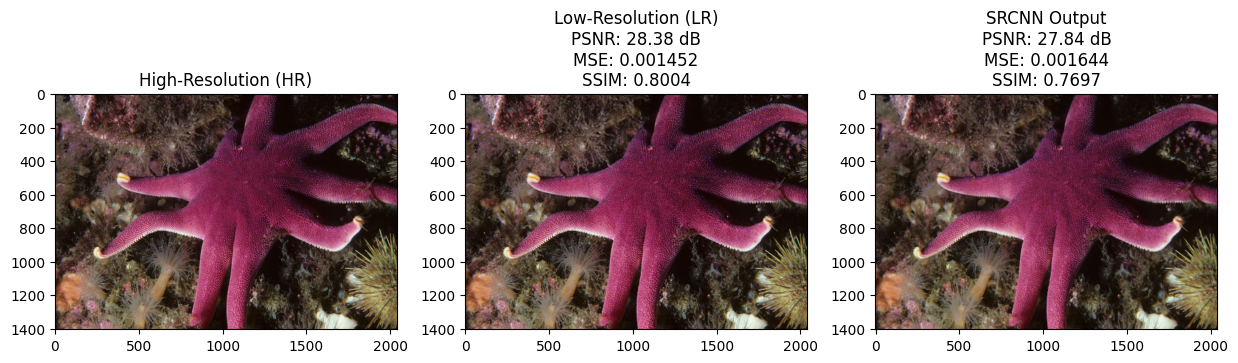

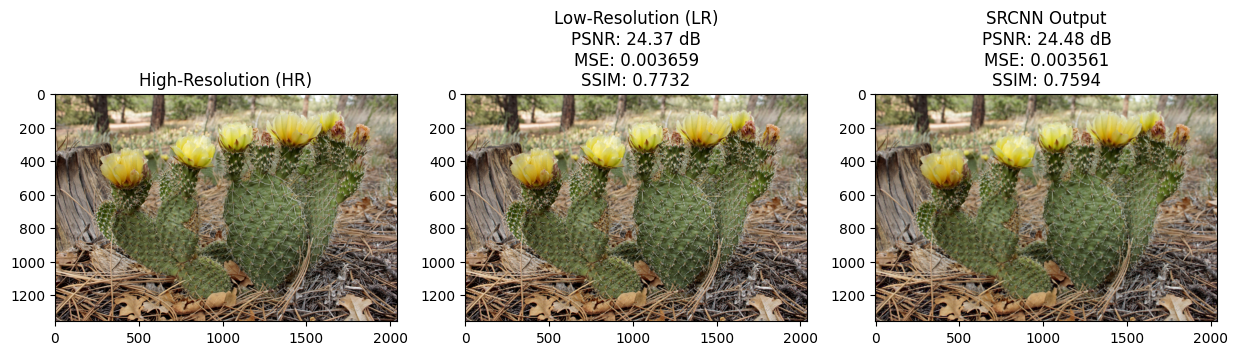

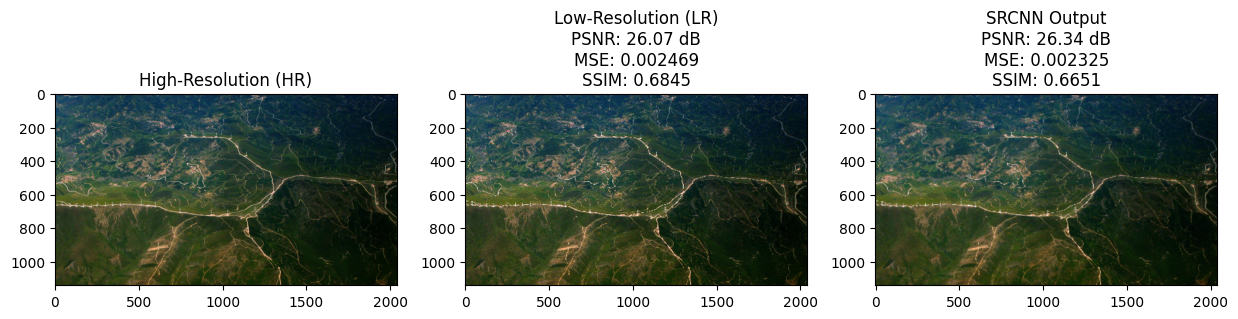

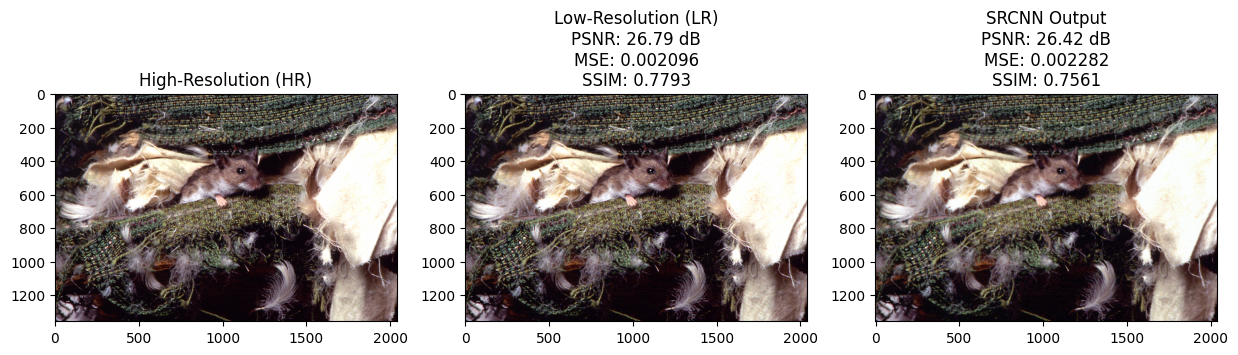

In [ ]:
# Load your trained SRCNN model
model = SRCNN()  # Replace with your model class
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/model.pth", map_location=device))
model.to(device)

# Define test images (modify the path accordingly)
test_images = [
    "/content/drive/MyDrive/DIV2k/train_hr/0001.png",
    "/content/drive/MyDrive/DIV2k/train_hr/0011.png",
    "/content/drive/MyDrive/DIV2k/train/DIV2K_train_HR/0330.png",
    "/content/drive/MyDrive/DIV2k/train/DIV2K_train_HR/0339.png"
]

# Run the test
test_model(model, test_images, scale_factor=4)